# Atomic Orbitals

\begin{equation}
{\cal H}\Psi(x) =\left[ -\frac{\hbar}{2 m} \nabla^2 - \frac{Z e^2}{4 \pi \epsilon_0 r}\right]\Psi(x) = E \Psi(x)
\end{equation}

\begin{equation}
\nabla^2= \frac{1}{r^2}\frac{\partial}{\partial r} \left(
r^2 \frac{\partial}{\partial r}
\right)+ 
\frac{1}{r^2 \sin \theta} \frac{\partial}{\partial \theta} \left(
\sin \theta \frac{\partial}{\partial \theta}
\right)+
\frac{1}{r^2 \sin^2 \theta} \frac{\partial^2}{\partial \phi^2}
\end{equation}



In [4]:
#Pkg.update();
#Pkg.add("GSL");
#Pkg.add("PyPlot");
using GSL;
using PyPlot;

\begin{equation}
    \rho=\frac{2r}{n a_0}
\end{equation}

\begin{equation}
        Y^m_l(θ,ϕ) = (-1)^m e^{i m \phi} P^m_l (\cos(θ))
\end{equation}
where $P^m_l (\cos (\theta))$ is the associated Legendre Polynomial.

\begin{equation}
    R^{n,l} (\rho) = \rho^l e^{-\rho/2} L^{2 l+1}_{n-l-1} (\rho)
\end{equation}
where $L^{2 l+1}_{n-l-1}(\rho)$ is the generalized Laguerre polynomial.  

\begin{equation}
    N=\sqrt{\left(\frac{2}{n}\right)^3 \frac{(n-l-1)}{2n(n+l)!}}
\end{equation}

#### Cell to Evaluate
What's below is a bunch of definitions that makes our calculations easier later on.  Here I utalize the Gnu scientific library, GSL imported above, to calculate the special functions.  

#### <b>Programming Tip!</b>
Even though its not necessary, specifying the type of inputs to a function through `m::Int` helps prevent improper inputs and allows the compiler to perform additional optimizations.  Julia also implements <i>Abstract Types</i>, so we don't have to specify the exact type of Int.  Real allows and numerical, non-complex type.  

Type greek characters in Jupyter notebooks via LaTeX syntax.  ex: \alpha+tab

The function `Orbital` throws `DomainError()` when `l` or `m` do not obey their bounds.  Julia supports a wide variety of easy to use error messages.

In [16]:
a0=1; #for convenience, or 5.2917721092(17)×10−11 m

# The unitless radial coordinate
ρ(r,n)=2r/(n*a0);

#The θ dependence
function Pmlh(m::Int,l::Int,θ::Real)
    return (-1)^m *sf_legendre_Plm(l,m,cos(θ)); 
end

#The θ and ϕ dependence
function Yml(m::Int,l::Int,θ::Real,ϕ::Real)
    return  (-1)^m*sf_legendre_Plm(l,m,cos(θ))*e^(im*m*ϕ)
end

#The Radial dependence
function R(n::Int,l::Int,ρ::Real)
     return sf_laguerre_n(n-l-1,2*l+1,ρ)*e^(-ρ/2)*ρ^l
end

#A normalization: This is dependent on the choice of polynomial representation
function norm(n::Int,l::Int)
    return sqrt((2/n)^3 * factorial(n-l-1)/(2n*factorial(n+l)))
end

#Generates an Orbital Funtion of (r,θ,ϕ) for a specificied n,l,m.  
function Orbital(n::Int,l::Int,m::Int)
    if l>=n    # we make sure l and m are within proper bounds    
        throw(DomainError())
    end
    if abs(m)>l
        throw(DomainError())
    end
    psi(ρ,θ,ϕ)=norm(n,l)*R(n,l,ρ)*Yml(m,l,θ,ϕ);
    return psi
end

#We will calculate is spherical coordinates, but plot in cartesian, so we need this array conversion
function SphtoCart(r::Array,θ::Array,ϕ::Array)
    x=r.*sin(θ).*cos(ϕ);
    y=r.*sin(θ).*sin(ϕ);
    z=r.*cos(θ);
    return x,y,z;
end

"Defined Helper Functions"

"Defined Helper Functions"

#### Parameters
Grid parameters:
You might need to change `rmax` to be able to view higher n orbitals.  

Remember that 
\begin{equation}
0<n \;\;\;\;\; \;\;\;\; 0 \leq l < n \;\;\;\;\; \;\;\;\; -l \leq m \leq l
\;\;\;\;\; \;\;\;\; n,l,m \in {\cal Z}
\end{equation}

In [17]:
# Grid Parameters
rmin=.05
rmax=5
Nr=100 #Sampling frequency
Nθ=100
Nϕ=100

# Choose which Orbital to look at
n=3;
l=1;
m=0;
"Defined parameters"

"Defined parameters"

In [19]:
#Linear Array of spherical coordinates
r=collect(linspace(rmin,rmax,Nr));
ϕ=collect(linspace(0,2π,Nθ));
θ=collect(linspace(0,π,Nϕ));
#3D arrays of spherical coordinates, in order r,θ,ϕ
ra=repeat(r,outer=[1,Nθ,Nϕ]);
θa=repeat(transpose(θ),outer=[Nr,1,Nϕ]);
ϕa=repeat(reshape(ϕ,1,1,Nϕ),outer=[Nr,Nθ,1]);

x,y,z=SphtoCart(ra,θa,ϕa);

Though I could create a wrapped up function with `Orbital(n,l,m)` and evaluate that at each point, the below evaluation takes advantage of the seperatability of the solution with respect to spherical dimensions.  The special functions, especially for higher modes, take time to calculate, and the fewer calls to GSL, the faster the code will run.  Therefore, this implementation copies over radial and angular responses.

In [21]:
Ψ=zeros(Float64,Nr,Nϕ,Nθ)
θd=Int64(round(Nθ/2))  ## gives approximately the equator.  Will be useful later

p1=Pmlh(m,l,θ[1]);
p2=exp(im*m*ϕ[1]);
for i in 1:Nr
    Ψ[i,1,1]=norm(n,l)*R(n,l,ρ(r[i],n))*p1*p2;
end

for j in 1:Nθ
    Ψ[:,j,1]=Ψ[:,1,1]*Pmlh(m,l,θ[j])/p1;
end

for k in 1:Nϕ
    Ψ[:,:,k]=Ψ[:,:,1]*exp(im*m*ϕ[k])/p2;
end

In [35]:
r[50]

2.5

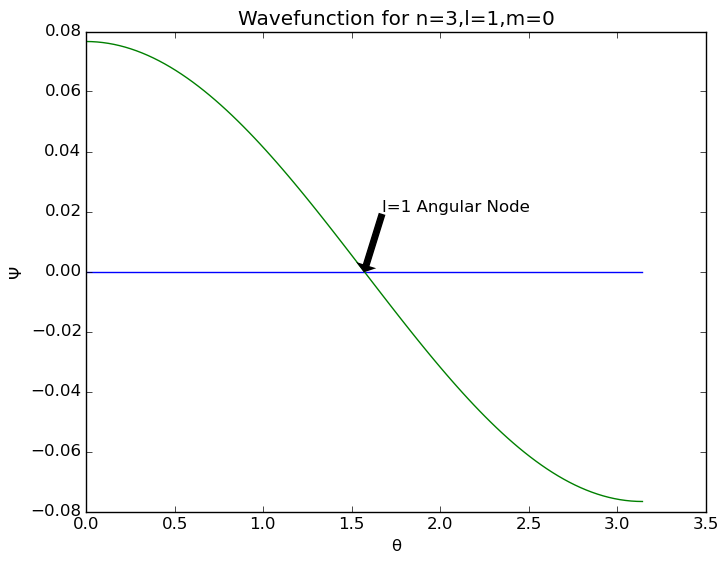

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f911dcc0d50>

In [45]:
pygui(false)
xlabel("θ")
ylabel("Ψ")
title("Wavefunction for n=3,l=1,m=0")

annotate("l=1 Angular Node",
xy=[π/2;0],
xytext=[π/2+.1;.02],
xycoords="data",
arrowprops=Dict("facecolor"=>"black"))

plot(θ,zeros(θ))
plot(θ,reshape(Ψ[50,:,1],100)) #reshape makes Ψ 1D

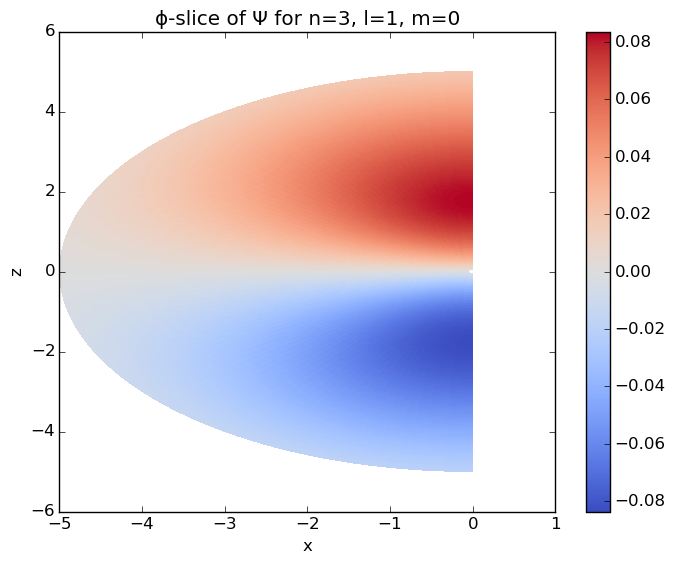

PyObject <matplotlib.colorbar.Colorbar instance at 0x7f911dc29758>

In [57]:
#rap=squeeze(ra[:,:,50],3)
#θap=squeeze(θa[:,:,50],3)
#ϕap=squeeze(ϕa[:,:,50],3)
#Ψp=squeeze(Ψ[:,:,50],3)
rap=ra[:,:,50]
θap=θa[:,:,50]
ϕap=ϕa[:,:,50]
Ψp=Ψ[:,:,50]
xp,yp,zp=SphtoCart(rap,θap,ϕap);
pygui(false)
xlabel("x")
ylabel("z")
title("ϕ-slice of Ψ for n=3, l=1, m=0")
pcolor(xp[:,:],zp[:,:],Ψp[:,:],cmap="coolwarm")
colorbar()

In [6]:
pygui(false)
contour(x[:,:,ϕd],y[:,:,ϕd],Ψ[:,:,ϕd])

pygui(false)
surf(x[:,:,ϕd],y[:,:,ϕd],Ψ[:,:,ϕd],linewidth=0,antialiased=false,cmap=ColorMap("cool"))

LoadError: LoadError: UndefVarError: x not defined
while loading In[6], in expression starting on line 2

In [60]:
rap=squeeze(ra[50,:,:],1)
θap=squeeze(θa[50,:,:],1)
ϕap=squeeze(ϕa[50,:,:],1)
Ψp=squeeze(Ψ[50,:,:],1)
xp,yp,zp=SphtoCart(rap,θap,ϕap);
pygui(false)
xlabel("x")
ylabel("z")
title("ϕ-slice of Ψ for n=3, l=1, m=0")
plot_surface(xp[:,:],xp[:,:],zp[:,:],Ψp[:,:],cmap="coolwarm")
colorbar()

/usr/lib/python2.7/dist-packages/matplotlib/collections.py:743: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0


LoadError: LoadError: PyError (:PyObject_Call) <type 'exceptions.ValueError'>
ValueError('could not broadcast input array from shape (100,100) into shape (100)',)
  File "/usr/lib/python2.7/dist-packages/mpl_toolkits/mplot3d/axes3d.py", line 1637, in plot_surface
    polyc = art3d.Poly3DCollection(polys, *args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/mpl_toolkits/mplot3d/art3d.py", line 476, in __init__
    PolyCollection.__init__(self, verts, *args, **kwargs)
  File "/usr/lib/python2.7/dist-packages/matplotlib/collections.py", line 800, in __init__
    self.set_sizes(sizes)
  File "/usr/lib/python2.7/dist-packages/matplotlib/collections.py", line 744, in set_sizes
    self._transforms[:, 0, 0] = scale

while loading In[60], in expression starting on line 10